In [1]:
import numpy as np
import gymnasium as gym
import torch 
from tqdm import tqdm
import matplotlib.pyplot as plt

# Policy Gradient Methods with Neural Networks. 

So far we have been able to implement REINFORCE with a simple policy parameterization, now we will move 
on to the more flexible case using neural networks to express the policy. 

Our first goal will be to use reinforce for the `CartPole` environment that we also met for DQN. 
Remember that this environment has a continous observation space with 4 entries and a discrete action space with 
two actions. 

So our first task is to make a network. We will use a similar strategy as did before with the network outputting two numbers 
that are converted to probabilities with a softmax function. 

In [ ]:
class PolicyNetwork(torch.nn.Module):

    def __init__(self, obs_size, n_actions, lr=1e-3):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(obs_size, 32)
        self.fc2 = torch.nn.Linear(32, n_actions)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_probabilities(self, x):
        # Calculate action preferences:
        prefs = self.forward(x)
        # Calculate probabilities using softmax (use torch's softmax as we we 
        # will need the gradient of it later.
        return torch.nn.functional.softmax(prefs, dim=-1)    

    def sample_action(self, x):
        probs = self.get_probabilities(x)
        action = torch.multinomial(probs, 1).item()
        return action, torch.log(probs[action])

Secondly we will implement the reinforce algorithm, I have included a `Trajectory`-class for conveniently storing the necessary information. 

The implementation differs little compared to our previous one, but there are some distinctions in relation to training. 
First off, before we did gradient ascent using something like

$\theta_{t+1} = \theta_t + \alpha * \nabla_\theta G \log(\pi(s, a))$

But using the gradient directly is more complicated in Torch, and regardless we would like to use one of the common optimizers for 
neural networks such as `Adam`. So we will recast this update rule as a loss and minimize that loss, that is we calculate 

$L = -G \log(\pi(s, a))$

The pseudocode says to loop over each time step of an episode and apply a gradient ascent update step, but rather than that we will 
sum the loss like so: 

$L = -\sum_t^T G_t \log(\pi(s_t, a_t)) $

Then we can use the backpropagation of Pytorch to get gradients of this loss function, minimization of which corresponds to the same 
update rule as we were using before. We could also have use e.g. `jax` or `torch.autograd` to directly get gradients of the log probability 
but this is more complicated programmatically even if it more closely follows the math. 

In [ ]:
class Trajectory:

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []

    def append(self, state, action, reward, log_prob):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)

    def __len__(self):
        return len(self.states)

class ReinforceAgent:

    def __init__(self, policy, env):
        self.policy = policy
        self.env = env

    def play_episode(self):

        state, _ = self.env.reset()
        terminal = False
        truncated = False

        trajectory = Trajectory()
        while not terminal and not truncated: 
            
            # Get the action and the corresponding log_prob from the policy. 
            # Remember to convert the state to a torch tensor. 
            action, log_probs = self.policy.sample_action(torch.tensor(state))

            # Take a step in the environment with the action:
            next_state, reward, terminal, truncated, info = self.env.step(action)

            # Append the step to the trajectory:
            trajectory.append(state, action, reward, log_probs)

            # Update the state:
            state = next_state

        return trajectory
    
    def update(self, trajectory, gamma):

        T = len(trajectory)

        # Calculate G_t for each time step
        G = []
        for t in range(T):
            Gt = np.sum([trajectory.rewards[k] * gamma**(k-t) for k in range(t, T)])
            G.append(Gt)
            
        G = torch.tensor(np.array(G))

        # Calculate the gradients of the log-prob
        log_probs_tensor = torch.stack(trajectory.log_probs)
        loss = -log_probs_tensor * G

        # Update the policy
        self.policy.optimizer.zero_grad()
        loss.sum().backward()
        self.policy.optimizer.step()

    def train(self, episodes=100, gamma=0.99):

        returns = np.zeros(episodes)

        for episode in tqdm(range(episodes)):

            # Play an episode:
            trajectory = self.play_episode()

            # Update the policy:
            self.update(trajectory, gamma)

            # Print the total reward of the episode:
            returns[episode] = np.sum(trajectory.rewards)

        return returns

Now our agent should be able to solve the `CartPole` environment, so lets try that. 

In [ ]:
env = gym.make('CartPole-v1')
policy = PolicyNetwork(4, 2, lr=1e-3)
agent = ReinforceAgent(policy, env)

returns = agent.train(episodes=1000, gamma=0.99)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:42<00:00, 23.32it/s]


Text(0, 0.5, 'Return')

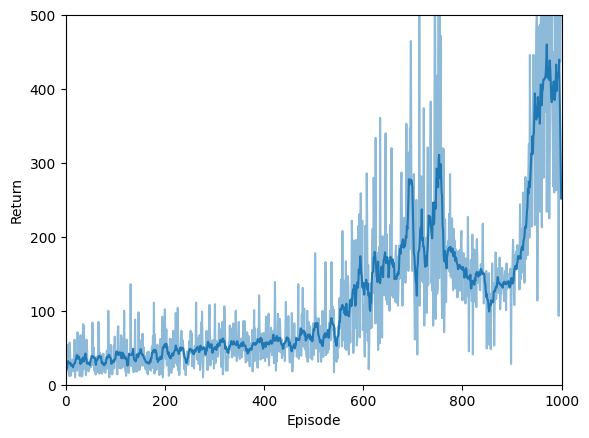

In [ ]:
def rolling_average(data, window=10):
    return np.convolve(data, np.ones(window), 'same') / window

episodes = np.arange(len(returns))

fig, ax = plt.subplots()

l1, = ax.plot(returns, alpha=0.5)
ax.plot(episodes, rolling_average(returns, 10), color=l1.get_color())

ax.set_xlim([0, len(returns)])
ax.set_ylim([0, 500])

ax.set_xlabel('Episode')
ax.set_ylabel('Return')

### REINFORCE with Baseline

At this point we have a working implementation of REINFORCE with a neural network 
for the policy parameterization, which is aweesome. But as we saw in the previous 
tutorial using a baseline can lead to higher learning performance. 

So we will implemenet the use of a baseline again, now using a neural network for 
the baseline. 

We will need a network that takes the state observation as input and outputs a single 
scalar for the state value prediction. We will then train this network towards 
the discouted returns $G$ and replace the use of $G$ in the policy updates with $\delta = G - V(s)$. 

To do this: 

1. Copy your code for the `ReinforceAgent` into the `ReinforceAgentBaseline` class below. 
2. Finish the code for the value network. 
3. Incoopeerate the value network in the `ReinforceAgentBaseline` by:
    - Adding `value` as a property that stores an instance of the `ValueNetwork`
    - Calculate the values for all states of the episodes (Make a tensor of the state representations and feed them to the network.)
    - Calculate $\delta$ 
    - Calculate the loss for the value network $\frac{1}{N}\sum_n^N \delta_i^2$
    - Replace $G$ with $\delta$ in the policy loss (Use `delta.detach()` to let Torch know that you dont need to backprop through $\delta$ for the policy update.)
    - Update both the policy and value networks with one gradient step (Remember to `zero_grad` fo both)

In [ ]:
class ValueNetwork(torch.nn.Module):

    def __init__(self, obs_size, lr=1e-3):
        super(ValueNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(obs_size, 32)
        self.fc2 = torch.nn.Linear(32, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ReinforceBaselineAgent:

    def __init__(self, policy, value, env):
        self.policy = policy
        self.value = value
        self.env = env

    def play_episode(self):

        state, _ = self.env.reset()
        terminal = False
        truncated = False

        trajectory = Trajectory()
        while not terminal and not truncated: 
            
            # Get the action and the corresponding log_prob from the policy. 
            # Remember to convert the state to a torch tensor. 
            action, log_probs = self.policy.sample_action(torch.tensor(state))

            # Take a step in the environment with the action:
            next_state, reward, terminal, truncated, info = self.env.step(action)

            # Append the step to the trajectory:
            trajectory.append(state, action, reward, log_probs)

            # Update the state:
            state = next_state

        return trajectory
    
    def update(self, trajectory, gamma):

        T = len(trajectory)

        # Calculate G_t for each time step
        G = []
        for t in range(T):
            Gt = np.sum([trajectory.rewards[k] * gamma**(k-t) for k in range(t, T)])
            G.append(Gt)
            
        G = torch.tensor(np.array(G))

        # Values: 
        states_tensor = torch.tensor(np.array(trajectory.states))
        values = self.value(states_tensor).squeeze()
        deltas = G - values

        # Loss of the value function:
        value_loss = deltas.pow(2).mean()

        # Calculate the gradients of the log-prob
        log_probs_tensor = torch.stack(trajectory.log_probs)
        loss = -log_probs_tensor * deltas.detach()

        # Update the policy
        self.policy.optimizer.zero_grad()
        loss.sum().backward()
        self.policy.optimizer.step()

        # Update the value function
        self.value.optimizer.zero_grad()
        value_loss.backward()
        self.value.optimizer.step()

    def train(self, episodes=100, gamma=0.99):

        returns = np.zeros(episodes)

        for episode in tqdm(range(episodes)):

            # Play an episode:
            trajectory = self.play_episode()

            # Update the policy:
            self.update(trajectory, gamma)

            # Print the total reward of the episode:
            returns[episode] = np.sum(trajectory.rewards)

        return returns

In [ ]:
env = gym.make('CartPole-v1')
policy = PolicyNetwork(4, 2, lr=5e-3) # Higher learning rate, that didnt work for me without baseline. 
value = ValueNetwork(4, lr=1e-2)
agent = ReinforceBaselineAgent(policy, value, env)

returns_baseline = agent.train(episodes=1000, gamma=0.99)

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


Text(0, 0.5, 'Return')

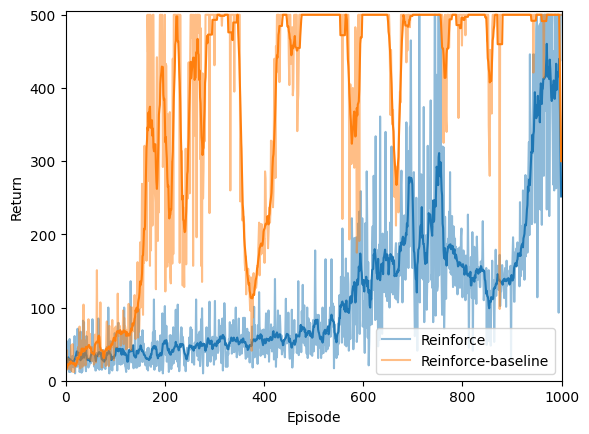

In [ ]:
def rolling_average(data, window=10):
    return np.convolve(data, np.ones(window), 'same') / window

episodes = np.arange(len(returns))

fig, ax = plt.subplots()

for R, label in zip([returns, returns_baseline], ['Reinforce', 'Reinforce-baseline']):
    l1, = ax.plot(episodes, R, alpha=0.5, label=label)
    ax.plot(episodes, rolling_average(R, 10), color=l1.get_color())

ax.set_xlim([0, len(returns)])
ax.set_ylim([0, 505])
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Return')

This covers the general idea of policy gradients, most of the algorithms building 
on REINFORCE do so by somehow reducing the variane of the gradient updates. 
E.g. in the popular Advantage Actor Critic (A2C) the advantage $A(s, a) = Q(s, a) - V(s)$ is used 
rather than just the value (see below exercise for more information.). The [Trust-Region Policy Optimization](https://spinningup.openai.com/en/latest/algorithms/trpo.html) (TRPO)
algorithm does this by ensuring that the gradients dont lead to 'too different' parameters using a 
constraint. Similarly the popular Proximal Policy Optimization [PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html), which is part of what is used to train ChatGPT and was the policy optimization method used in the work of Gregor Simms et. al. on RL for molecular structures, clips gradients in a specific way to ensure that updates don't change the parameters too much. Though 
there does exist policy optimization algorithms such [Deep Deterministic Policy Gradients](https://spinningup.openai.com/en/latest/algorithms/ddpg.html) (DDPG) that come at the policy 
optimization problem from a Q-learning perspective. 

#### Optional Exerecise: Continuous Action space. 

So far we have looked at problems with a discrete action spaces, but it is 
not too complicated to extend REINFORCE and its derivatives to work with continuous environments. 
The general idea here is that our network is used to parameterize some probability distribution, 
e.g. we can predict the mean and variance of a normal distribution and draw actions from that 
distribution. 

We need derivatives through the sampling from the distribution, which is some tedious math, but lucky 
for us this can be handled by Pytorch automatically. 

Adapt your implementation of REINFORCE (or probably REINFORCE with baseline) for continous 
action spaces. Use it to solve an environment with a continouos action such as [Mountain Car Continouos](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) or [Mujoco Inverted Pendelum](https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/), probably the latter is the better option as even [PPO has trouble solving mountain car](https://docs.cleanrl.dev/rl-algorithms/ppo/#experiment-results) probably due to sparse rewards and an on-policy algorithm. 

For some help with the implementation, see the [Training using REINFORCE for Mujoco](https://gymnasium.farama.org/tutorials/training_agents/reinforce_invpend_gym_v26/) tutorial of the Gymnasium documentation. 

#### Optional Exercise: Bootstrapping. 

Having implemented REINFORCE with baseline we can now discuss the use of bootstrapping. 
We trained our value function towards the Monte-Carlo sample of the return $G$, that is

$
G(s_t) = \sum_{k=t}^T \gamma^{k-t} r_t
$

In order to calculate this for time step $t$ we neeed all other time steps until $T$, and 
all we have is a sample of what this might be. Our update rule then amount to 

$
V(s_t) \leftarrow V(s_t) + \alpha(G(s_t) - V(s_t)) = V(s_t) + \alpha \delta(s_t)
$

Which is what we did when implementing REINFORCE with baseline. For example consider $G_0$ that is the return 
from the first state $s_0$, this depends on all succeeding steps, it is easy to imagine that the 
initial state might a state of high-value and that the first action also is good leading to 
another good state but that over the whole trajectory we get a poor return due to suboptimal 
choices later on. 

What we have gathered in an episode is obviously a possible trajectory under the current 
policy, but it is just a sample - it has variance and sometimes high variance. The value function 
is supposed to approximate the *expectation* of the return but we are training it towards examples 
of the return and hoping that over many attempts we gradually obtain an appropriate approximation of 
the expectation. 

We can alleviate the high variance of this stochastic (Monte Carlo) process with bootstrapping a 
[definition](https://datascience.stackexchange.com/questions/26938/what-exactly-is-bootstrapping-in-reinforcement-learning) of bootstrapping could be given as 
> Using one or more estimated values in the update step for the same kind of estimated value.  

Or from Sutton & Barto

> All of them update (Dynamic Programming methods) estimates of the values of states based on estimates of the values of successor states. That is, they update estimates on the basis of other estimates. We call this general idea bootstrapping.

It might be easier to understand with some math: 

$V(s_t) \leftarrow V(s, t) + \alpha [r_t + \gamma V(s_{t+1}) - V(s_t)]$

That is instead of looking at the entire trajectory we use just the reward we recieved $r_t$ from state $s_t$ and our discounted 
prediction of the value of the next state $\gamma V(s_{t+1})$. So we rely less on the full trajectory so there will be less variance but there is a bias introduced by our approximate value function. This bootstrapping principle can be generalized

$V(s_t) \leftarrow V(s_t) + \alpha \left[\sum_{k=t}^{\tau-1} \gamma^{k-t} r_t + \gamma^{\tau-t} V(s_\tau)-V(s_t) \right]$

So here we include some number of the actually observed rewards which if $\tau = T$ reproduces the non-bootstrapped equation (using that $V(s_T) = 0$, which is true by definition). So the number of steps to look forward can be tuned, more steps increases variance, fewer steps increases bias. If you were present for the journal club on this [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8103164&tag=1), you might recall this figure 
<div>
<img src="images/bootstrapping.png" width="500"/>
</div>

Which in the bottom part (attempts to) describe exactly this principle, bootstrapping lets us move between the one-step temporal differeence 
which is one-step bootstrapping to Monte-Carlo which is $\infty$-step bootstrapping and is what we have been doing so far. 

**Now for the actual exercise**: Take your REINFORCE with baseline code and implemeent one-step bootstrapping for the training of the value network. (If feeling adventures try multi-step bootstrapping or even implement full variable step bootstrapping). 

Note, that when using bootstrapping we can make our algorithm online, that is we do not 
need to collect an entire trajectory to train - we need only to collect as many steps 
as we use in the bootstrapping. That means that agent can learn while exploring the environment, 
rather than in betweeen. 

#### Optional Exercise: Advantage Actor Critic (A2C). 

This requires, at least reading, the previous optional exercise. 

Now that we have implemnted REINFORCE with baseline, and with a bootstrapped value function, we can 
now look at Actor-Critic methods, in particular we can look at the Advantage Actor Critic. To explain the 
the terminology, this quote from Sutton & Barto may help 

> Although the REINFORCE-with-baseline method learns both a policy and a state-value
function, we do not consider it to be an actor–critic method because its state-value function
is used only as a baseline, not as a critic. That is, it is not used for bootstrapping (updating
the value estimate for a state from the estimated values of subsequent states), but only
as a baseline for the state whose estimate is being updated

(Though by some other definitions any algorihm that learns a state-value or action-value in conjunction with the 
policy are considered Actor-Critic methods.)

So in actor-critic methods the policy training is stabilized by using a bootstrapped baseline. 
One of the most popular actor-critic methods is Advantage Actor Critic with the surprisingly reasonable acronym A2C. 
Here the advantage function is used as the bootstrapped baseline. The advantage is given by 

$A(s, a) = Q(s, a) - V(s)$

So it represents how much extra reward an action leads to in the current state, i.e. the advantage of action compared to the other actions. 
However, it is generally frowned upon having to learn both $Q$ and $V$, but luckily the advantage can be estimated using just the value function 

$A(s_t, a_t) = r_t + \gamma V(s_{t+1}) - V(s_t)$

From my exploration of these methods it seems that A2C implementations almost always use [Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438), so it may be necessary to implement that to get a functional algorithm, see lines 214-227 of the [CleanRL PPO implementation](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py). 

#### Optional Exercise: PPO using CleanRL or StableBaselines

Try the [CleanRL](https://github.com/vwxyzjn/cleanrl/tree/master) implementation of [PPO](https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/ppo.py) or [StableBaselines](https://github.com/DLR-RM/stable-baselines3) the on the CartPole probleem. 

### Conclusion: 

The next tutorial is on creating an environment for atomistic optimization with RL in `tutorial05`. 